<a href="https://colab.research.google.com/github/Seonwoo-Yun/Seonwoo-Yun.github.io/blob/master/DQN_Pacman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym
!pip install gym[atari]
!pip install gym[accept-rom-license]
!pip install numpy==1.23.5

INFO: pip is looking at multiple versions of gym[atari] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 48.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.8 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827727 sha256=9bfd52a7b3006ab0178577ce34fcf7930a857dcb4d91648256ccad9668e4128b
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.11.0
    Uninstalling ale-py-0.11.0:
      Successfully uninstalled 

# 1.Convolutional network for DQN
Input:last 4 frame of (84,84) size image

output:Q values for state s(dim=number of actions)


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')
from PreprocessPacman import make_env
import torch
import torch.nn as nn
import numpy as np
import gym
import copy
from tqdm import tqdm
device='cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

#(channel,height,width):1*84*84->32*20*20->64*9*9->64*7*7
class Network(nn.Module):
    def __init__(self,linear_input_dim=64*7*7):
        super().__init__()
        self.Conv_layers=nn.Sequential(nn.Conv2d(4,32,kernel_size=8,stride=4),
                                       nn.ReLU(),
                                       nn.Conv2d(32,64,kernel_size=3,stride=2),
                                       nn.ReLU(),
                                       nn.Conv2d(64,64,kernel_size=3,stride=1),
                                       nn.ReLU())
        self.linear_layers=nn.Sequential(nn.Linear(linear_input_dim,512),nn.ReLU(),nn.Linear(512,9))
    def forward(self,x):
        x=self.Conv_layers(x)
        x=x.reshape((len(x),-1))
        x=self.linear_layers(x)
        return x

cuda:0


# 2.Replay Buffer:Store
Store (state,action,reward,next_state,done) pair and return batch for training.


In [ ]:
class ReplayBuffer:
    def __init__(self,memory_size):
        self.memory_size=memory_size
        self.size=0
        self.idx=0
        self.state_mem=np.empty(memory_size,dtype=np.ndarray)
        self.action_mem=np.empty(memory_size,dtype=np.ndarray)
        self.reward_mem=np.empty(memory_size,dtype=np.ndarray)
        self.next_state_mem=np.empty(memory_size,dtype=np.ndarray)
        self.done_mem=np.empty(memory_size,dtype=np.ndarray)
    def store(self,experience):
        s,a,r,ns,d=experience
        self.idx=self.idx%self.memory_size
        self.state_mem[self.idx]=s
        self.action_mem[self.idx]=a
        self.reward_mem[self.idx]=r
        self.next_state_mem[self.idx]=ns
        self.done_mem[self.idx]=d
        self.idx+=1
        self.size+=1
        self.size=np.minimum(self.size,self.memory_size)
    def get_sample(self,batch_size):
        idx=np.random.choice(self.size,batch_size,replace=False)
        state_batch=np.vstack(self.state_mem[idx])
        action_batch=np.vstack(self.action_mem[idx])
        reward_batch=np.vstack(self.reward_mem[idx])
        next_state_batch=np.vstack(self.next_state_mem[idx])
        done_batch=np.vstack(self.done_mem[idx])
        return state_batch,action_batch,reward_batch,next_state_batch,done_batch


# 3.DQN method

In [ ]:
class DQN():
    def __init__(self,env,online_model,target_model,train_strategy,test_strategy,replay_buffer,optimizer,loss_fn,
                 lr,gamma,n_episode,batch_size,update_period,replay_start_size):
        self.env=env
        self.online_model=online_model
        self.target_model=target_model
        self.train_strategy=train_strategy
        self.test_strategy=test_strategy
        self.replay_buffer=replay_buffer
        self.optimizer=optimizer
        self.loss_fn=loss_fn
        self.lr=lr
        self.gamma=gamma
        self.n_episode=n_episode
        self.batch_size=batch_size
        self.update_period=update_period
        self.replay_start_size=replay_start_size
        self.step=0
        self.episode=0
        self.rewards=[]
        self.best_mean_reward=0.0

    def train(self):
        for episode in tqdm(range(self.n_episode)):
            self.episode+=1
            self.train_strategy.update_epsilon()
            self.rewards.append(0.0)
            s=self.env.reset()
            done=False
            while not done:
                s=torch.from_numpy(s).unsqueeze(0).to(device)
                Qs=self.online_model(s)
                a=self.train_strategy.select_action(Qs)
                ns,r,tm,tr,info=self.env.step(a)
                self.rewards[-1]+=r
                done=tm or tr
                self.replay_buffer.store([np.array(s.cpu()),a,r,np.expand_dims(ns,0),float(done)])
                self.step+=1
                s=ns
                if self.step%self.update_period==0:
                    self.update_target()
                if self.step>=self.replay_start_size:
                    states,actions,rewards,next_states,dones=self.replay_buffer.get_sample(self.batch_size)
                    states=torch.from_numpy(states).float().to(device)
                    actions=torch.from_numpy(actions).long().to(device)
                    rewards=torch.from_numpy(rewards).float().to(device)
                    next_states=torch.from_numpy(next_states).float().to(device)
                    dones=torch.from_numpy(dones).float().to(device)

                    Qs=self.online_model(states)
                    Q_sa=torch.gather(Qs,1,actions)
                    Qns=self.target_model(next_states).detach()
                    Qns_max=Qns.max(axis=1)[0].unsqueeze(1)
                    Q_target=rewards+self.gamma*Qns_max*(1-dones)
                    #파라미터 학습
                    loss=self.loss_fn(Q_sa,Q_target)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
            mean_reward=np.mean(self.rewards[-100:])
            if mean_reward>self.best_mean_reward:
              print(f'best_mean_reward:{self.best_mean_reward}->{mean_reward}')
              self.best_mean_reward=mean_reward
            if self.episode%100==0:
              self.save_model()

    def update_target(self):
        self.target_model.load_state_dict(self.online_model.state_dict())
    def evaluate(self,n_episode=1):
        total_rewards=np.zeros(n_episode)
        for i in range(n_episode):
            total_reward=0
            s=self.env.reset()
            done=False
            while not done:
                s=torch.from_numpy(s).unsqueeze(0).to(device)
                Qs=self.online_model(s)
                a=self.test_strategy.select_action(Qs)
                ns,r,terminated,truncated,_=self.env.step(a)
                done=terminated or truncated
                total_reward+=r
                s=ns
            total_rewards[i]=total_reward
        return total_rewards.mean()
    def save_model(self):
      path='/content/drive/MyDrive/DQN-Pacman.tar'
      torch.save({'online_model':self.online_model.state_dict(),
                  'target_model':self.target_model.state_dict(),
                  'optimizer':self.optimizer.state_dict(),
                  'train_strategy':self.train_strategy,
                  'current_episode':self.episode,
                  'current_step':self.step,
                  'rewards':self.rewards,
                  'best_reward':self.best_mean_reward
                  },path)



In [ ]:
class greedy():
  def __init__(self):
      pass
  def select_action(self,Qs):
       return Qs.argmax().item()

class lin_epsilon_greedy():
  def __init__(self,init_epsilon=1.0,min_epsilon=0.1,decay_steps=10000):
    self.init_epsilon=init_epsilon
    self.min_epsilon=min_epsilon
    self.decay_steps=decay_steps
    self.episode=0
  def update_epsilon(self):
    self.episode+=1
    if self.episode<=self.decay_steps:
        self.epsilon=self.min_epsilon+(self.init_epsilon-self.min_epsilon)*(1-self.episode/self.decay_steps)
    else:
        self.epsilon=self.min_epsilon

  def select_action(self,Qs):
    p=np.random.rand()
    if p>self.epsilon:
      action=Qs.argmax().item()
    else:
      action=np.random.choice(Qs.shape[-1])
    return action


# 4.Training

In [ ]:
#hyperparameters
gamma=0.99
lr=0.00025
init_epsilon=1.0
last_epsilon=0.1
epsilon_decay_steps=1500
batch_size=32
episode_n=15000
replay_size=10**5
replay_start_size=5000
update_period=10**4

env=gym.make('ALE/MsPacman-v5',obs_type='grayscale',frameskip=1)
env=make_env(env)
online_model=Network().to(device)
target_model=copy.deepcopy(online_model).to(device)
train_strategy=lin_epsilon_greedy(init_epsilon,last_epsilon,epsilon_decay_steps)
test_strategy=greedy()
replay_buffer=ReplayBuffer(replay_size)
optimizer=torch.optim.RMSprop(online_model.parameters(),lr)
loss_fn=nn.MSELoss()

agent=DQN(env,online_model,target_model,train_strategy,test_strategy,replay_buffer,optimizer,loss_fn,
          lr,gamma,episode_n,batch_size,update_period,replay_start_size)

agent.train()




/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(
  0%|          | 1/15000 [00:01<5:32:52,  1.33s/it]

best_mean_reward:0.0->330.0


  0%|          | 2/15000 [00:01<3:46:45,  1.10it/s]

best_mean_reward:330.0->400.0


  0%|          | 14/15000 [00:08<2:26:52,  1.70it/s]

best_mean_reward:400.0->407.14285714285717


  0%|          | 15/15000 [00:09<2:35:26,  1.61it/s]

best_mean_reward:407.14285714285717->420.6666666666667


  0%|          | 16/15000 [00:09<2:43:44,  1.53it/s]

best_mean_reward:420.6666666666667->467.5


  0%|          | 35/15000 [00:19<2:26:19,  1.70it/s]

best_mean_reward:467.5->524.2857142857143


  1%|          | 109/15000 [02:10<7:16:17,  1.76s/it]

best_mean_reward:524.2857142857143->537.6


  1%|          | 110/15000 [02:11<6:51:22,  1.66s/it]

best_mean_reward:537.6->538.7


  1%|          | 125/15000 [02:34<6:22:20,  1.54s/it]

best_mean_reward:538.7->541.7


  2%|▏         | 257/15000 [05:59<6:56:05,  1.69s/it]

best_mean_reward:541.7->541.9


  2%|▏         | 258/15000 [06:00<6:10:25,  1.51s/it]

best_mean_reward:541.9->542.3


  2%|▏         | 370/15000 [08:50<7:49:30,  1.93s/it]

best_mean_reward:542.3->549.0


  2%|▏         | 371/15000 [08:52<8:20:58,  2.05s/it]

best_mean_reward:549.0->553.4


  2%|▏         | 374/15000 [08:58<7:48:51,  1.92s/it]

best_mean_reward:553.4->554.8


  3%|▎         | 376/15000 [09:01<7:29:52,  1.85s/it]

best_mean_reward:554.8->556.3


  3%|▎         | 377/15000 [09:03<7:26:29,  1.83s/it]

best_mean_reward:556.3->559.2


  3%|▎         | 378/15000 [09:04<7:14:53,  1.78s/it]

best_mean_reward:559.2->559.8


  3%|▎         | 379/15000 [09:07<7:43:41,  1.90s/it]

best_mean_reward:559.8->561.2


  3%|▎         | 380/15000 [09:08<7:02:52,  1.74s/it]

best_mean_reward:561.2->561.3


  3%|▎         | 402/15000 [09:45<7:55:30,  1.95s/it]

best_mean_reward:561.3->562.2


  3%|▎         | 439/15000 [10:50<7:57:01,  1.97s/it]

best_mean_reward:562.2->562.7


  3%|▎         | 448/15000 [11:07<7:30:02,  1.86s/it]

best_mean_reward:562.7->566.7


  3%|▎         | 450/15000 [11:11<7:52:16,  1.95s/it]

best_mean_reward:566.7->567.8


  3%|▎         | 461/15000 [11:29<7:00:16,  1.73s/it]

best_mean_reward:567.8->568.2


  3%|▎         | 462/15000 [11:32<7:51:56,  1.95s/it]

best_mean_reward:568.2->583.1


  3%|▎         | 465/15000 [11:37<7:42:55,  1.91s/it]

best_mean_reward:583.1->587.4


  3%|▎         | 467/15000 [11:42<8:47:54,  2.18s/it]

best_mean_reward:587.4->605.2


  3%|▎         | 475/15000 [11:56<7:28:15,  1.85s/it]

best_mean_reward:605.2->607.3


  3%|▎         | 486/15000 [12:13<5:45:20,  1.43s/it]

best_mean_reward:607.3->608.3


  3%|▎         | 487/15000 [12:14<6:01:07,  1.49s/it]

best_mean_reward:608.3->609.8


  3%|▎         | 502/15000 [12:41<8:51:39,  2.20s/it]

best_mean_reward:609.8->613.2


  3%|▎         | 503/15000 [12:43<8:26:48,  2.10s/it]

best_mean_reward:613.2->614.8


  3%|▎         | 510/15000 [12:54<7:56:15,  1.97s/it]

best_mean_reward:614.8->625.1


  3%|▎         | 512/15000 [12:59<8:33:02,  2.12s/it]

best_mean_reward:625.1->626.0


  3%|▎         | 513/15000 [13:00<7:29:47,  1.86s/it]

best_mean_reward:626.0->627.1


  3%|▎         | 517/15000 [13:07<7:51:08,  1.95s/it]

best_mean_reward:627.1->642.7


  3%|▎         | 518/15000 [13:09<7:20:04,  1.82s/it]

best_mean_reward:642.7->645.2


  3%|▎         | 519/15000 [13:10<6:54:26,  1.72s/it]

best_mean_reward:645.2->646.4


  3%|▎         | 523/15000 [13:18<7:47:08,  1.94s/it]

best_mean_reward:646.4->656.1


  4%|▎         | 525/15000 [13:21<7:22:58,  1.84s/it]

best_mean_reward:656.1->658.9


  4%|▎         | 531/15000 [13:30<6:17:54,  1.57s/it]

best_mean_reward:658.9->659.0


  4%|▎         | 533/15000 [13:33<6:39:01,  1.65s/it]

best_mean_reward:659.0->661.5


  4%|▍         | 608/15000 [15:46<7:44:31,  1.94s/it]

best_mean_reward:661.5->670.4


  4%|▍         | 609/15000 [15:48<8:00:38,  2.00s/it]

best_mean_reward:670.4->674.7


  4%|▍         | 654/15000 [17:10<7:35:48,  1.91s/it]

best_mean_reward:674.7->684.8


  4%|▍         | 655/15000 [17:12<7:41:23,  1.93s/it]

best_mean_reward:684.8->687.4


  4%|▍         | 656/15000 [17:15<9:12:09,  2.31s/it]

best_mean_reward:687.4->702.6


  4%|▍         | 657/15000 [17:18<9:01:09,  2.26s/it]

best_mean_reward:702.6->708.3


  5%|▌         | 765/15000 [20:39<8:00:45,  2.03s/it]

best_mean_reward:708.3->711.3


  5%|▌         | 766/15000 [20:42<8:21:11,  2.11s/it]

best_mean_reward:711.3->712.7


  5%|▌         | 771/15000 [20:49<7:14:50,  1.83s/it]

best_mean_reward:712.7->714.2


  5%|▌         | 777/15000 [21:00<7:46:10,  1.97s/it]

best_mean_reward:714.2->716.5


  5%|▌         | 779/15000 [21:04<7:37:14,  1.93s/it]

best_mean_reward:716.5->721.2


  5%|▌         | 790/15000 [21:24<8:08:31,  2.06s/it]

best_mean_reward:721.2->722.4


  5%|▌         | 791/15000 [21:27<8:55:49,  2.26s/it]

best_mean_reward:722.4->733.8


  5%|▌         | 811/15000 [22:03<8:06:58,  2.06s/it]

best_mean_reward:733.8->736.4


  5%|▌         | 812/15000 [22:04<7:41:44,  1.95s/it]

best_mean_reward:736.4->743.2


  5%|▌         | 814/15000 [22:08<7:23:11,  1.87s/it]

best_mean_reward:743.2->749.1


  5%|▌         | 815/15000 [22:10<7:35:57,  1.93s/it]

best_mean_reward:749.1->750.4


  6%|▌         | 831/15000 [22:36<7:04:40,  1.80s/it]

best_mean_reward:750.4->753.2


  6%|▌         | 833/15000 [22:40<7:22:09,  1.87s/it]

best_mean_reward:753.2->772.4


  6%|▌         | 834/15000 [22:42<8:03:53,  2.05s/it]

best_mean_reward:772.4->779.2


  6%|▌         | 876/15000 [23:59<9:01:32,  2.30s/it]

best_mean_reward:779.2->780.4


  6%|▌         | 879/15000 [24:07<10:18:56,  2.63s/it]

best_mean_reward:780.4->783.7


  6%|▌         | 881/15000 [24:11<8:52:01,  2.26s/it]

best_mean_reward:783.7->789.0


  6%|▌         | 882/15000 [24:13<8:39:33,  2.21s/it]

best_mean_reward:789.0->791.4


  6%|▌         | 883/15000 [24:15<8:47:46,  2.24s/it]

best_mean_reward:791.4->794.3


  6%|▌         | 889/15000 [24:26<7:59:04,  2.04s/it]

best_mean_reward:794.3->805.2


  6%|▌         | 902/15000 [24:53<8:46:33,  2.24s/it]

best_mean_reward:805.2->809.5


  6%|▌         | 908/15000 [25:04<7:57:37,  2.03s/it]

best_mean_reward:809.5->815.0


  6%|▌         | 920/15000 [25:26<7:48:01,  1.99s/it]

best_mean_reward:815.0->830.8


  6%|▌         | 922/15000 [25:29<7:38:45,  1.96s/it]

best_mean_reward:830.8->835.3


  7%|▋         | 1039/15000 [29:21<8:42:10,  2.24s/it]

best_mean_reward:835.3->837.4


  7%|▋         | 1042/15000 [29:28<8:14:28,  2.13s/it]

best_mean_reward:837.4->839.5


  7%|▋         | 1043/15000 [29:30<8:37:17,  2.22s/it]

best_mean_reward:839.5->840.0


  7%|▋         | 1044/15000 [29:32<8:16:55,  2.14s/it]

best_mean_reward:840.0->845.3


  7%|▋         | 1047/15000 [29:38<8:13:13,  2.12s/it]

best_mean_reward:845.3->850.0


  7%|▋         | 1051/15000 [29:47<8:19:29,  2.15s/it]

best_mean_reward:850.0->850.4


  7%|▋         | 1055/15000 [29:54<7:35:03,  1.96s/it]

best_mean_reward:850.4->851.7


  7%|▋         | 1063/15000 [30:08<7:37:52,  1.97s/it]

best_mean_reward:851.7->854.3


  7%|▋         | 1064/15000 [30:11<8:19:35,  2.15s/it]

best_mean_reward:854.3->854.9


  7%|▋         | 1066/15000 [30:14<7:42:09,  1.99s/it]

best_mean_reward:854.9->860.3


  7%|▋         | 1070/15000 [30:23<8:23:06,  2.17s/it]

best_mean_reward:860.3->866.1


  7%|▋         | 1071/15000 [30:25<8:11:34,  2.12s/it]

best_mean_reward:866.1->867.6


  7%|▋         | 1072/15000 [30:27<8:56:53,  2.31s/it]

best_mean_reward:867.6->875.6


  7%|▋         | 1074/15000 [30:31<7:45:43,  2.01s/it]

best_mean_reward:875.6->878.1


  7%|▋         | 1075/15000 [30:32<7:30:07,  1.94s/it]

best_mean_reward:878.1->882.9


  7%|▋         | 1076/15000 [30:34<7:12:37,  1.86s/it]

best_mean_reward:882.9->885.3


  7%|▋         | 1078/15000 [30:39<7:46:07,  2.01s/it]

best_mean_reward:885.3->886.6


  7%|▋         | 1080/15000 [30:42<7:35:46,  1.96s/it]

best_mean_reward:886.6->886.9


  7%|▋         | 1093/15000 [31:09<7:41:16,  1.99s/it]

best_mean_reward:886.9->893.7


  7%|▋         | 1094/15000 [31:12<8:09:06,  2.11s/it]

best_mean_reward:893.7->903.1


  7%|▋         | 1095/15000 [31:14<8:29:31,  2.20s/it]

best_mean_reward:903.1->904.5


  7%|▋         | 1107/15000 [31:36<7:36:30,  1.97s/it]

best_mean_reward:904.5->905.2


  7%|▋         | 1112/15000 [31:46<8:13:24,  2.13s/it]

best_mean_reward:905.2->906.7


  7%|▋         | 1113/15000 [31:49<8:48:35,  2.28s/it]

best_mean_reward:906.7->908.4


  7%|▋         | 1117/15000 [31:57<8:34:51,  2.23s/it]

best_mean_reward:908.4->916.1


  8%|▊         | 1125/15000 [32:12<8:22:10,  2.17s/it]

best_mean_reward:916.1->916.6


  8%|▊         | 1129/15000 [32:20<8:19:25,  2.16s/it]

best_mean_reward:916.6->918.1


  8%|▊         | 1204/15000 [34:52<8:28:40,  2.21s/it]

best_mean_reward:918.1->919.8


  8%|▊         | 1205/15000 [34:53<8:11:21,  2.14s/it]

best_mean_reward:919.8->921.5


  8%|▊         | 1206/15000 [34:56<8:43:10,  2.28s/it]

best_mean_reward:921.5->928.6


  8%|▊         | 1209/15000 [35:04<10:03:01,  2.62s/it]

best_mean_reward:928.6->936.1


  8%|▊         | 1215/15000 [35:15<7:20:17,  1.92s/it]

best_mean_reward:936.1->936.2


  8%|▊         | 1216/15000 [35:17<7:34:20,  1.98s/it]

best_mean_reward:936.2->940.2


  8%|▊         | 1221/15000 [35:30<8:33:42,  2.24s/it]

best_mean_reward:940.2->943.6


  8%|▊         | 1223/15000 [35:34<8:07:54,  2.12s/it]

best_mean_reward:943.6->948.6


  8%|▊         | 1224/15000 [35:36<8:47:35,  2.30s/it]

best_mean_reward:948.6->956.8


  8%|▊         | 1226/15000 [35:41<9:11:51,  2.40s/it]

best_mean_reward:956.8->961.5


  8%|▊         | 1227/15000 [35:43<8:57:14,  2.34s/it]

best_mean_reward:961.5->964.5


  8%|▊         | 1230/15000 [35:51<9:23:22,  2.45s/it]

best_mean_reward:964.5->968.8


  8%|▊         | 1236/15000 [36:03<8:02:39,  2.10s/it]

best_mean_reward:968.8->969.9


  8%|▊         | 1237/15000 [36:06<7:57:21,  2.08s/it]

best_mean_reward:969.9->970.6


  8%|▊         | 1238/15000 [36:07<7:23:57,  1.94s/it]

best_mean_reward:970.6->973.0


  8%|▊         | 1242/15000 [36:16<8:04:45,  2.11s/it]

best_mean_reward:973.0->973.6


  8%|▊         | 1256/15000 [36:44<8:25:36,  2.21s/it]

best_mean_reward:973.6->975.5


  8%|▊         | 1257/15000 [36:46<8:27:26,  2.22s/it]

best_mean_reward:975.5->989.4


  8%|▊         | 1258/15000 [36:49<9:19:13,  2.44s/it]

best_mean_reward:989.4->996.5


  8%|▊         | 1264/15000 [37:01<7:35:58,  1.99s/it]

best_mean_reward:996.5->1004.1


  8%|▊         | 1265/15000 [37:03<8:03:30,  2.11s/it]

best_mean_reward:1004.1->1006.7


  8%|▊         | 1266/15000 [37:05<8:09:03,  2.14s/it]

best_mean_reward:1006.7->1016.5


  8%|▊         | 1269/15000 [37:11<7:38:21,  2.00s/it]

best_mean_reward:1016.5->1019.7


  8%|▊         | 1270/15000 [37:13<7:37:21,  2.00s/it]

best_mean_reward:1019.7->1025.8


  8%|▊         | 1271/15000 [37:15<7:30:30,  1.97s/it]

best_mean_reward:1025.8->1027.3


  9%|▊         | 1280/15000 [37:33<8:22:08,  2.20s/it]

best_mean_reward:1027.3->1029.6


  9%|▊         | 1291/15000 [37:58<8:26:32,  2.22s/it]

best_mean_reward:1029.6->1031.3


  9%|▉         | 1349/15000 [40:06<9:05:53,  2.40s/it]

best_mean_reward:1031.3->1032.9


  9%|▉         | 1350/15000 [40:08<9:23:24,  2.48s/it]

best_mean_reward:1032.9->1043.6


  9%|▉         | 1351/15000 [40:11<9:33:13,  2.52s/it]

best_mean_reward:1043.6->1048.0


  9%|▉         | 1352/15000 [40:14<9:48:45,  2.59s/it]

best_mean_reward:1048.0->1059.6


  9%|▉         | 1365/15000 [40:43<8:42:56,  2.30s/it]

best_mean_reward:1059.6->1065.9


  9%|▉         | 1367/15000 [40:48<9:14:16,  2.44s/it]

best_mean_reward:1065.9->1071.5


  9%|▉         | 1369/15000 [40:52<8:31:59,  2.25s/it]

best_mean_reward:1071.5->1071.6


  9%|▉         | 1371/15000 [40:58<9:18:41,  2.46s/it]

best_mean_reward:1071.6->1076.4


  9%|▉         | 1372/15000 [40:59<8:25:50,  2.23s/it]

best_mean_reward:1076.4->1079.5


  9%|▉         | 1373/15000 [41:02<9:14:45,  2.44s/it]

best_mean_reward:1079.5->1087.4


  9%|▉         | 1374/15000 [41:04<8:49:11,  2.33s/it]

best_mean_reward:1087.4->1092.9


  9%|▉         | 1375/15000 [41:07<9:02:49,  2.39s/it]

best_mean_reward:1092.9->1100.9


  9%|▉         | 1376/15000 [41:10<9:39:51,  2.55s/it]

best_mean_reward:1100.9->1110.6


  9%|▉         | 1378/15000 [41:14<8:40:01,  2.29s/it]

best_mean_reward:1110.6->1113.9


  9%|▉         | 1380/15000 [41:19<9:30:47,  2.51s/it]

best_mean_reward:1113.9->1137.9


  9%|▉         | 1381/15000 [41:21<8:50:46,  2.34s/it]

best_mean_reward:1137.9->1140.1


  9%|▉         | 1382/15000 [41:24<9:08:30,  2.42s/it]

best_mean_reward:1140.1->1140.4


  9%|▉         | 1383/15000 [41:26<8:57:28,  2.37s/it]

best_mean_reward:1140.4->1147.1


  9%|▉         | 1395/15000 [41:51<8:33:29,  2.26s/it]

best_mean_reward:1147.1->1152.8


  9%|▉         | 1396/15000 [41:54<8:53:54,  2.35s/it]

best_mean_reward:1152.8->1160.3


  9%|▉         | 1399/15000 [42:00<7:59:42,  2.12s/it]

best_mean_reward:1160.3->1161.6


  9%|▉         | 1400/15000 [42:02<8:11:30,  2.17s/it]

best_mean_reward:1161.6->1163.5


  9%|▉         | 1403/15000 [42:08<7:58:43,  2.11s/it]

best_mean_reward:1163.5->1164.8


  9%|▉         | 1406/15000 [42:15<8:07:16,  2.15s/it]

best_mean_reward:1164.8->1167.1


  9%|▉         | 1407/15000 [42:17<7:28:02,  1.98s/it]

best_mean_reward:1167.1->1170.2


  9%|▉         | 1419/15000 [42:48<10:50:14,  2.87s/it]

best_mean_reward:1170.2->1174.4


  9%|▉         | 1420/15000 [42:51<10:46:11,  2.86s/it]

best_mean_reward:1174.4->1180.5


  9%|▉         | 1421/15000 [42:54<10:53:45,  2.89s/it]

best_mean_reward:1180.5->1188.3


 10%|▉         | 1432/15000 [43:19<9:58:00,  2.64s/it]

best_mean_reward:1188.3->1217.1


 10%|▉         | 1437/15000 [43:33<10:28:25,  2.78s/it]

best_mean_reward:1217.1->1221.8


 10%|▉         | 1439/15000 [43:39<11:10:06,  2.96s/it]

best_mean_reward:1221.8->1232.3


 10%|▉         | 1440/15000 [43:42<11:25:27,  3.03s/it]

best_mean_reward:1232.3->1239.2


 10%|▉         | 1441/15000 [43:44<10:25:25,  2.77s/it]

best_mean_reward:1239.2->1245.0


 10%|▉         | 1445/15000 [43:53<8:50:38,  2.35s/it]

best_mean_reward:1245.0->1245.9


 10%|▉         | 1446/15000 [43:56<9:45:42,  2.59s/it]

best_mean_reward:1245.9->1252.7


 10%|▉         | 1451/15000 [44:10<10:42:22,  2.84s/it]

best_mean_reward:1252.7->1253.5


 10%|▉         | 1454/15000 [44:19<10:53:49,  2.90s/it]

best_mean_reward:1253.5->1256.5


 10%|█         | 1502/15000 [46:17<10:16:11,  2.74s/it]

best_mean_reward:1256.5->1257.4


 10%|█         | 1503/15000 [46:20<10:32:25,  2.81s/it]

best_mean_reward:1257.4->1263.6


 10%|█         | 1505/15000 [46:24<9:24:25,  2.51s/it] 

best_mean_reward:1263.6->1265.4


 10%|█         | 1506/15000 [46:27<9:43:24,  2.59s/it]

best_mean_reward:1265.4->1269.9


 10%|█         | 1507/15000 [46:30<9:39:12,  2.58s/it]

best_mean_reward:1269.9->1277.4


 10%|█         | 1509/15000 [46:34<9:07:08,  2.43s/it]

best_mean_reward:1277.4->1282.8


 10%|█         | 1510/15000 [46:36<8:07:43,  2.17s/it]

best_mean_reward:1282.8->1287.8


 10%|█         | 1511/15000 [46:39<9:19:23,  2.49s/it]

best_mean_reward:1287.8->1296.0


 10%|█         | 1512/15000 [46:41<9:09:16,  2.44s/it]

best_mean_reward:1296.0->1296.8


 10%|█         | 1513/15000 [46:44<9:20:28,  2.49s/it]

best_mean_reward:1296.8->1298.6


 10%|█         | 1515/15000 [46:48<8:15:39,  2.21s/it]

best_mean_reward:1298.6->1300.3


 10%|█         | 1525/15000 [47:10<9:11:21,  2.46s/it]

best_mean_reward:1300.3->1309.7


 10%|█         | 1528/15000 [47:17<8:37:32,  2.30s/it]

best_mean_reward:1309.7->1312.9


 10%|█         | 1529/15000 [47:20<9:03:32,  2.42s/it]

best_mean_reward:1312.9->1320.0


 10%|█         | 1530/15000 [47:22<9:28:41,  2.53s/it]

best_mean_reward:1320.0->1320.5


 10%|█         | 1531/15000 [47:26<10:29:57,  2.81s/it]

best_mean_reward:1320.5->1330.0


 12%|█▏        | 1751/15000 [56:13<9:42:30,  2.64s/it]

best_mean_reward:1330.0->1334.0


 12%|█▏        | 1752/15000 [56:15<9:43:59,  2.64s/it]

best_mean_reward:1334.0->1336.0


 12%|█▏        | 1753/15000 [56:18<10:18:45,  2.80s/it]

best_mean_reward:1336.0->1337.8


 12%|█▏        | 1754/15000 [56:21<9:40:16,  2.63s/it] 

best_mean_reward:1337.8->1341.1


 12%|█▏        | 1755/15000 [56:23<9:16:28,  2.52s/it]

best_mean_reward:1341.1->1344.0


 12%|█▏        | 1762/15000 [56:42<10:07:54,  2.76s/it]

best_mean_reward:1344.0->1348.3


 12%|█▏        | 1763/15000 [56:45<9:24:16,  2.56s/it] 

best_mean_reward:1348.3->1357.8


 14%|█▍        | 2084/15000 [1:10:11<9:18:46,  2.60s/it]

best_mean_reward:1357.8->1358.3


 14%|█▍        | 2099/15000 [1:10:53<10:42:56,  2.99s/it]

best_mean_reward:1358.3->1376.1


 14%|█▍        | 2100/15000 [1:10:56<10:51:22,  3.03s/it]

best_mean_reward:1376.1->1384.4


 14%|█▍        | 2101/15000 [1:10:59<9:53:44,  2.76s/it] 

best_mean_reward:1384.4->1385.3


 14%|█▍        | 2104/15000 [1:11:06<9:08:10,  2.55s/it]

best_mean_reward:1385.3->1389.3


 14%|█▍        | 2105/15000 [1:11:08<9:06:43,  2.54s/it]

best_mean_reward:1389.3->1396.7


 14%|█▍        | 2108/15000 [1:11:16<9:21:22,  2.61s/it]

best_mean_reward:1396.7->1404.1


 14%|█▍        | 2114/15000 [1:11:32<9:27:58,  2.64s/it]

best_mean_reward:1404.1->1407.7


 14%|█▍        | 2115/15000 [1:11:35<9:43:00,  2.71s/it]

best_mean_reward:1407.7->1408.0


 14%|█▍        | 2116/15000 [1:11:37<9:27:24,  2.64s/it]

best_mean_reward:1408.0->1409.5


 14%|█▍        | 2117/15000 [1:11:40<9:08:26,  2.55s/it]

best_mean_reward:1409.5->1415.1


 15%|█▍        | 2232/15000 [1:16:44<9:40:35,  2.73s/it]

best_mean_reward:1415.1->1421.8


 15%|█▍        | 2234/15000 [1:16:51<10:41:50,  3.02s/it]

best_mean_reward:1421.8->1425.7


 15%|█▍        | 2235/15000 [1:16:53<10:08:35,  2.86s/it]

best_mean_reward:1425.7->1426.5


 15%|█▍        | 2236/15000 [1:16:56<10:05:46,  2.85s/it]

best_mean_reward:1426.5->1426.9


 15%|█▍        | 2239/15000 [1:17:05<10:32:45,  2.98s/it]

best_mean_reward:1426.9->1431.2


 15%|█▍        | 2240/15000 [1:17:07<10:11:10,  2.87s/it]

best_mean_reward:1431.2->1442.1


 15%|█▍        | 2241/15000 [1:17:10<9:54:10,  2.79s/it] 

best_mean_reward:1442.1->1450.8


 15%|█▍        | 2242/15000 [1:17:13<10:38:31,  3.00s/it]

best_mean_reward:1450.8->1459.1


 15%|█▍        | 2243/15000 [1:17:17<11:07:40,  3.14s/it]

best_mean_reward:1459.1->1465.7


 15%|█▍        | 2244/15000 [1:17:19<10:30:26,  2.97s/it]

best_mean_reward:1465.7->1470.9


 15%|█▍        | 2245/15000 [1:17:22<9:38:13,  2.72s/it] 

best_mean_reward:1470.9->1471.5


 15%|█▍        | 2247/15000 [1:17:26<9:01:49,  2.55s/it]

best_mean_reward:1471.5->1480.7


 15%|█▌        | 2263/15000 [1:18:10<10:22:02,  2.93s/it]

best_mean_reward:1480.7->1492.0


 15%|█▌        | 2264/15000 [1:18:12<9:49:30,  2.78s/it] 

best_mean_reward:1492.0->1499.9


 15%|█▌        | 2316/15000 [1:20:31<10:28:28,  2.97s/it]

best_mean_reward:1499.9->1518.8


 19%|█▊        | 2805/15000 [1:42:07<7:23:57,  2.18s/it]


KeyboardInterrupt: 

#5.1.1 Reward history as learning proceeds
hyperparameters:
gamma=0.99

lr=0.00025

init_epsilon=1.0

last_epsilon=0.1

epsilon decay episodes=10000

batch_size=32

episode_n=14100

replay_size=100000

replay_start_size=5000

update_period=10000

Result:DQN model doesn't learn well. Maybe epsilon scheduling was potential problem. Because epsilon decays too slow in this set up.(epsilon decay episodes/max_episode~0.71)

total learning episode: 14100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


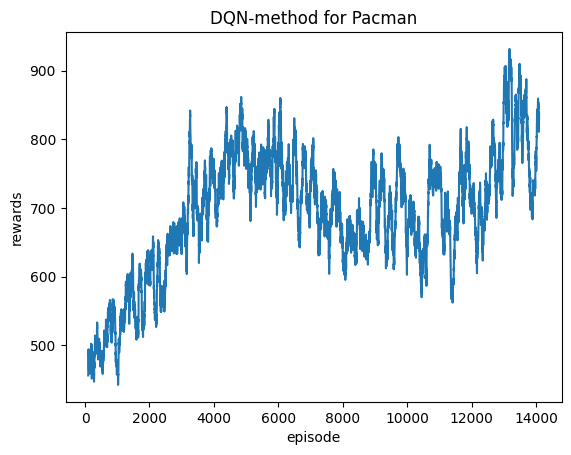

current_epsilon 0.1


In [ ]:
import matplotlib.pyplot as plt
checkpoint=torch.load('/content/drive/MyDrive/DQN-Pacman-lin1.tar',
                      weights_only=False,map_location=torch.device('cpu'))
episode=checkpoint['current_episode']
rewards=checkpoint['rewards']
print('total learning episode:',episode)
x=np.arange(len(rewards))
rewards=np.array(rewards)
mean_100rewards=np.zeros_like(rewards)
for i in range(len(rewards)):
  mean_100rewards[i]=np.mean(rewards[i-99:i+1])

plt.plot(x,mean_100rewards)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.title('DQN-method for Pacman')
plt.show()
st=checkpoint['train_strategy']
print('current_epsilon',st.epsilon)


# 5.1.2 Test for 100games using trained model

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


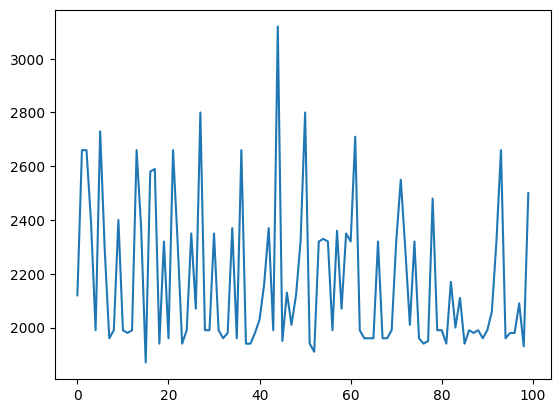

mean rewards of 100 test games 2177.5


In [ ]:
model=Network().to(device)
model.load_state_dict(checkpoint['online_model'])
test_strategy=greedy()
total_rewards=np.zeros(100)
env=gym.make('ALE/MsPacman-v5',obs_type='grayscale',frameskip=1)
env=make_env(env)
for i in range(100):
    total_reward=0
    s=env.reset()
    done=False
    while not done:
        s=torch.from_numpy(s).unsqueeze(0).to(device)
        Qs=model(s)
        a=test_strategy.select_action(Qs)
        ns,r,terminated,truncated,_=env.step(a)
        done=terminated or truncated
        total_reward+=r
        s=ns
    total_rewards[i]=total_reward
x=np.arange(len(total_rewards))
plt.plot(x,total_rewards)
plt.show()
print('mean rewards of 100 test games',total_rewards.mean())

#5.2.1 Reward history as learning proceeds

hyperparameters:
episode_n=15000

epsilon decay episodes=1500

other values of parameters are same as above setting

total learning episode: 14900
best 100 mean reward: 3227.1


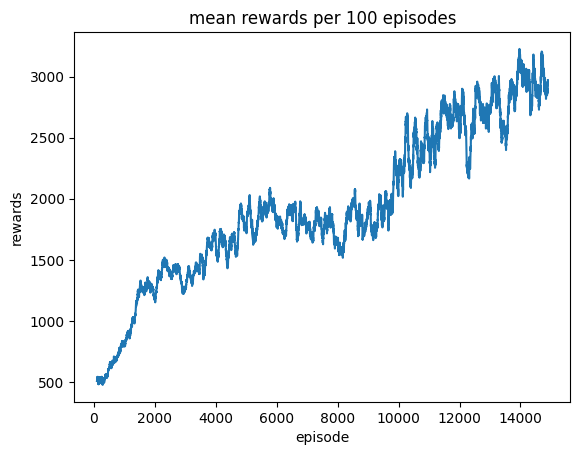

current_epsilon 0.1


In [ ]:
import matplotlib.pyplot as plt
checkpoint=torch.load('/content/drive/MyDrive/DQN-Pacman.tar',
                      weights_only=False,map_location=torch.device('cuda:0'))
episode=checkpoint['current_episode']
rewards=checkpoint['rewards']
print('total learning episode:',episode)
print('best 100 mean reward:',checkpoint['best_reward'])
x=np.arange(len(rewards))
rewards=np.array(rewards)
mean_100rewards=np.zeros_like(rewards)
for i in range(len(rewards)):
   mean_100rewards[i]=np.mean(rewards[i-99:i+1])

plt.plot(x,mean_100rewards)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.title('mean rewards per 100 episodes')
plt.show()
st=checkpoint['train_strategy']
print('current_epsilon',st.epsilon)


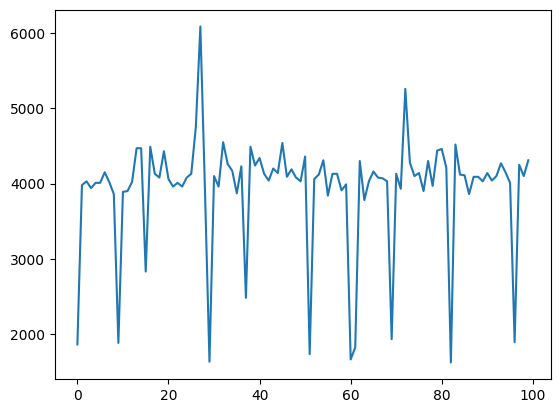

mean rewards of 100 test games 3924.4


In [ ]:
model=Network().to(device)
model.load_state_dict(checkpoint['online_model'])
test_strategy=greedy()
total_rewards=np.zeros(100)
env=gym.make('ALE/MsPacman-v5',obs_type='grayscale',frameskip=1)
env=make_env(env)
for i in range(100):
    total_reward=0
    s=env.reset()
    done=False
    while not done:
        s=torch.from_numpy(s).unsqueeze(0).to(device)
        Qs=model(s)
        a=test_strategy.select_action(Qs)
        ns,r,terminated,truncated,_=env.step(a)
        done=terminated or truncated
        total_reward+=r
        s=ns
    total_rewards[i]=total_reward
x=np.arange(len(total_rewards))
plt.plot(x,total_rewards)
plt.show()
print('mean rewards of 100 test games',total_rewards.mean())

In [ ]:
gamma=0.99
lr=0.00025
batch_size=32
episode_n=2900
replay_size=10**5
replay_start_size=5000
update_period=10**4

checkpoint=torch.load('/content/drive/MyDrive/DQN-Pacman.tar',weights_only=False)
env=gym.make('ALE/MsPacman-v5',obs_type='grayscale',frameskip=1)
env=make_env(env)
online_model=Network().to(device)
target_model=Network().to(device)
optimizer=torch.optim.RMSprop(online_model.parameters(),lr=lr)
online_model.load_state_dict(checkpoint['online_model'])
target_model.load_state_dict(checkpoint['target_model'])
optimizer.load_state_dict(checkpoint['optimizer'])
train_strategy=checkpoint['train_strategy']
test_strategy=greedy()
replay_buffer=ReplayBuffer(memory_size=10**5)
loss_fn=nn.MSELoss()
agent=DQN(env,online_model,target_model,train_strategy,test_strategy,replay_buffer,optimizer,loss_fn,
          lr,gamma,episode_n,batch_size,update_period,replay_start_size)

agent.episode=checkpoint['current_episode']
agent.rewards=checkpoint['rewards']
agent.best_mean_reward=checkpoint['best_reward']
agent.train()


 15%|█▍        | 428/2900 [18:50<2:18:01,  3.35s/it]

best_mean_reward:2901.1->2904.5


 15%|█▍        | 429/2900 [18:53<2:13:43,  3.25s/it]

best_mean_reward:2904.5->2923.6


 15%|█▍        | 430/2900 [18:55<1:54:56,  2.79s/it]

best_mean_reward:2923.6->2925.0


 17%|█▋        | 479/2900 [21:21<2:01:12,  3.00s/it]

best_mean_reward:2925.0->2927.7


 17%|█▋        | 480/2900 [21:24<1:58:34,  2.94s/it]

best_mean_reward:2927.7->2950.6


 17%|█▋        | 481/2900 [21:27<1:59:56,  2.97s/it]

best_mean_reward:2950.6->2956.3


 17%|█▋        | 482/2900 [21:30<2:04:49,  3.10s/it]

best_mean_reward:2956.3->2959.3


 35%|███▍      | 1012/2900 [45:51<1:23:10,  2.64s/it]

best_mean_reward:2959.3->2983.4


 35%|███▌      | 1024/2900 [46:22<1:30:18,  2.89s/it]

best_mean_reward:2983.4->2986.1


 36%|███▌      | 1032/2900 [46:43<1:23:26,  2.68s/it]

best_mean_reward:2986.1->2986.3


 36%|███▌      | 1047/2900 [47:21<1:11:42,  2.32s/it]

best_mean_reward:2986.3->2991.6


 36%|███▌      | 1049/2900 [47:27<1:23:38,  2.71s/it]

best_mean_reward:2991.6->3002.2


 36%|███▌      | 1050/2900 [47:29<1:16:58,  2.50s/it]

best_mean_reward:3002.2->3003.2


 41%|████      | 1194/2900 [54:01<1:16:44,  2.70s/it]

best_mean_reward:3003.2->3005.3


 62%|██████▏   | 1803/2900 [1:21:57<49:21,  2.70s/it]

best_mean_reward:3005.3->3016.1


 62%|██████▏   | 1804/2900 [1:22:01<55:43,  3.05s/it]

best_mean_reward:3016.1->3044.3


 63%|██████▎   | 1817/2900 [1:22:36<52:02,  2.88s/it]

best_mean_reward:3044.3->3059.5


 63%|██████▎   | 1818/2900 [1:22:38<49:58,  2.77s/it]

best_mean_reward:3059.5->3062.0


 63%|██████▎   | 1819/2900 [1:22:41<51:25,  2.85s/it]

best_mean_reward:3062.0->3069.2


 63%|██████▎   | 1820/2900 [1:22:45<53:23,  2.97s/it]

best_mean_reward:3069.2->3084.2


 63%|██████▎   | 1821/2900 [1:22:47<50:22,  2.80s/it]

best_mean_reward:3084.2->3099.5


 63%|██████▎   | 1822/2900 [1:22:50<51:19,  2.86s/it]

best_mean_reward:3099.5->3107.9


 63%|██████▎   | 1823/2900 [1:22:53<50:22,  2.81s/it]

best_mean_reward:3107.9->3120.7


 63%|██████▎   | 1825/2900 [1:22:58<49:23,  2.76s/it]

best_mean_reward:3120.7->3128.2


 63%|██████▎   | 1826/2900 [1:23:01<52:33,  2.94s/it]

best_mean_reward:3128.2->3129.1


 63%|██████▎   | 1829/2900 [1:23:10<54:14,  3.04s/it]

best_mean_reward:3129.1->3143.4


 64%|██████▍   | 1850/2900 [1:24:10<50:09,  2.87s/it]

best_mean_reward:3143.4->3161.5


 64%|██████▍   | 1862/2900 [1:24:43<46:40,  2.70s/it]

best_mean_reward:3161.5->3180.6


 64%|██████▍   | 1864/2900 [1:24:48<45:37,  2.64s/it]

best_mean_reward:3180.6->3181.7


 64%|██████▍   | 1865/2900 [1:24:52<51:53,  3.01s/it]

best_mean_reward:3181.7->3189.8


 64%|██████▍   | 1867/2900 [1:24:56<46:08,  2.68s/it]

best_mean_reward:3189.8->3199.3


 64%|██████▍   | 1868/2900 [1:24:59<49:20,  2.87s/it]

best_mean_reward:3199.3->3227.1


 83%|████████▎ | 2397/2900 [1:49:21<23:14,  2.77s/it]